## 2D Finite Differences

torch.Size([784])


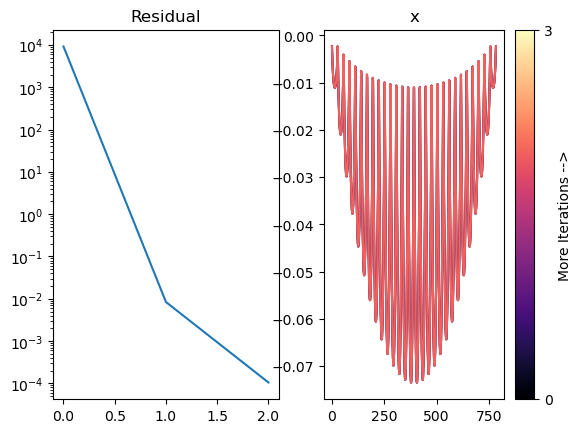

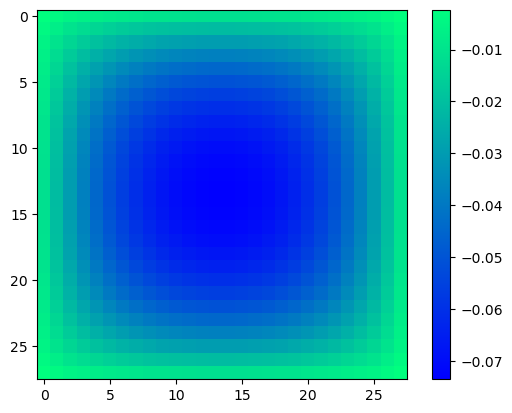

In [182]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import utils

def true_N(big_u):
    u = big_u[:, 0:1]
    ux = big_u[:, 1:2]
    uy = big_u[:, 2:3]
    uxx = big_u[:, 3:4]
    uxy = big_u[:, 4:5]
    uyy = big_u[:, 5:6]

    return uxx + uyy - 1.0

def make_big_u(u, x, y):
    """
    makes (batch, 6) tensor for N_fun, using finite differences of u

    :param u: 2D tensor of shape (n_x, n_y) (BCs included)
    :param x: 1D tensor of shape (n_x,) or (n_x, 1)
    :param y: 1D tensor of shape (n_y,) or (n_y, 1)
    """
    ux = utils.fd_centered(u, x)
    uy = utils.fd_centered(u.T, y).T
    uxx = utils.fd_centered_2nd(u, x)
    uxy = utils.fd_centered(ux.T, y).T
    uyy = utils.fd_centered_2nd(u.T, y).T

    u_same_grid = u[1:-1, 1:-1]
    ux_same_grid = ux[:, 1:-1]
    uy_same_grid = uy[1:-1, :]
    uxx_same_grid = uxx[:, 1:-1]
    uxy_same_grid = uxy
    uyy_same_grid = uyy[1:-1, :]

    big_u = torch.stack([u_same_grid, ux_same_grid, uy_same_grid, \
                         uxx_same_grid, uxy_same_grid, uyy_same_grid], dim=2)
    big_u = big_u.reshape(-1, big_u.shape[2])
    return big_u

n_x = 30
n_y = 30
x = torch.linspace(0, 1, n_x)
y = torch.linspace(0, 1, n_y)
X, Y = torch.meshgrid(x, y)
X_r = X.ravel().unsqueeze(1)
Y_r = Y.ravel().unsqueeze(1)

def residual(u_int_fl):
    u = torch.zeros(n_x, n_y)
    u[1:-1, 1:-1] = u_int_fl.reshape(n_x-2, n_y-2)
    big_u = make_big_u(u, x, y)
    N = true_N(big_u).squeeze()
    return N

u_int_fl = torch.ones((n_x-2)*(n_y-2))
res = residual(u_int_fl)
print(res.shape)

u_int_solve = utils.newton_solve(residual, u_int_fl, debug=True)
u_int = torch.reshape(u_int_solve, (n_x-2, n_y-2))
plt.figure()
plt.imshow(u_int, cmap='winter')
plt.colorbar()

u_data = 8*u_int

In [183]:
u_data = 8*u_int

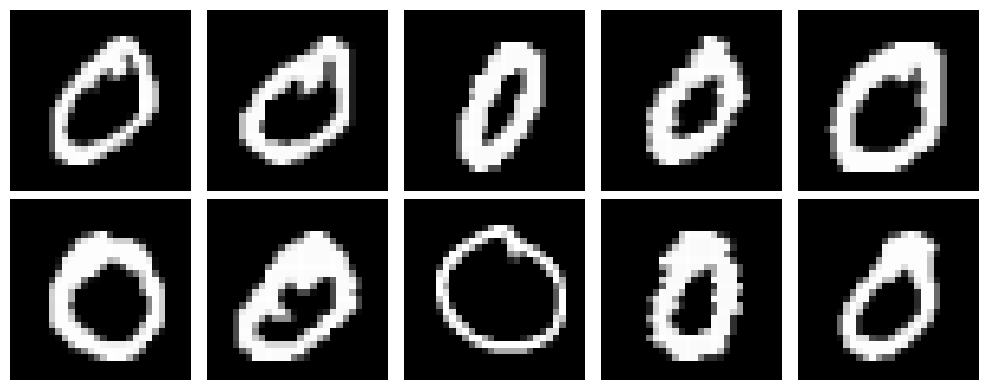

In [184]:
# load mnist dataset
import torchvision

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
images = mnist_train.data
classifications = mnist_train.targets
# get only the zeros
images = (images[classifications == 0]) / 255.0
def show_example_images(images):
    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        axs[i // 5, i % 5].imshow(images[i], cmap='gray')
        axs[i // 5, i % 5].axis('off')
    plt.tight_layout()

show_example_images(images)
image = images[0]
u_data = 1-image

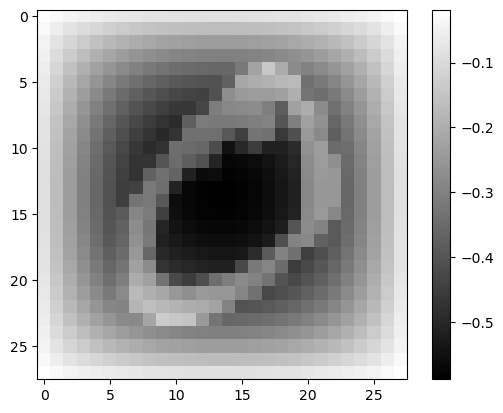

In [185]:
u_data = 0.2*image + 8*u_int
# u_data = 8*u_int

plt.figure()
plt.imshow(u_data, cmap='gray')
plt.colorbar()

Text(0.5, 1.0, 'Initial N Solution')

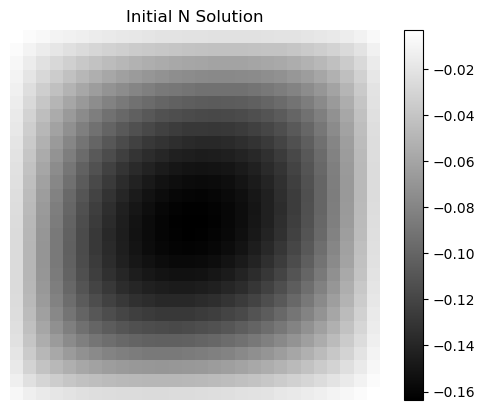

In [186]:
from modules import SimpleFNN, SineActivation, Siren
class StabN(nn.Module):
    def __init__(self, N_dnn, stab_term=1e-2):
        super(StabN, self).__init__()
        self.N_dnn = N_dnn
        self.stab_term = stab_term

    def forward(self, big_u):
        uxx = big_u[:, 3:4]
        uyy = big_u[:, 5:6]
        stab_mult = self.stab_term * (uxx + uyy)
        N = self.N_dnn(big_u)
        return N + stab_mult

# layers = [6, 3, 1]
torch.manual_seed(0)
# N_dnn = SimpleFNN(layers, SineActivation())
# N_siren = Siren(in_features=6, out_features=1, hidden_features=5, hidden_layers=1,
N_siren = Siren(in_features=6, out_features=1, hidden_features=12, hidden_layers=2,
              first_omega_0=0.5, hidden_omega_0=1)

N_dnn = StabN(N_siren, stab_term=5*10**-1)
# N_dnn = N_siren

class PDE_Image(nn.Module):
    def __init__(self, N_dnn, n_x, n_y):
        super(PDE_Image, self).__init__()
        self.N_dnn = N_dnn
        self.n_x = n_x
        self.n_y = n_y
        self.x = torch.linspace(0, 1, n_x + 2)
        self.y = torch.linspace(0, 1, n_y + 2)
        self.u0_int = torch.ones((n_x)*(n_y))

    def get_residual(self, u_int_fl):
        u = torch.zeros(self.n_x + 2, self.n_y + 2)
        u[1:-1, 1:-1] = u_int_fl.reshape(self.n_x, self.n_y)
        big_u = make_big_u(u, self.x, self.y)
        # prepend x,y so N(x,y,u,ux,uy,uxx,uxy,uyy)
        # x_r = self.x[1:-1].unsqueeze(1).repeat(1, self.n_y)
        # y_r = self.y[1:-1].unsqueeze(0).repeat(self.n_x, 1)
        # big_u = torch.cat([x_r.reshape(-1).unsqueeze(1),
        #                     y_r.reshape(-1).unsqueeze(1), big_u], dim=1)
        N = self.N_dnn(big_u).squeeze()
        return N

    def normalize(self, u):
        # u_min = u.min()
        # u_max = u.max()
        # u = (u - u_min) / (u_max - u_min)
        return u

    def forward(self):
        u_pred = utils.newton_solve(self.get_residual, self.u0_int, max_iter=10)
        u_pred_img = u_pred.reshape(self.n_x, self.n_y)
        u_pred_img = self.normalize(u_pred_img)
        return u_pred_img


pde_img_model = PDE_Image(N_dnn, *image.shape)
u_pred_img = pde_img_model()

plt.figure()
plt.imshow(u_pred_img.detach(), cmap='grey')
plt.colorbar()
plt.axis('off')
plt.title('Initial N Solution')

Epoch 1/10000, Loss: 0.046002767980098724
Parameter 0 gradient norm: 1.42e-01
Parameter 1 gradient norm: 9.07e-02
Parameter 2 gradient norm: 5.75e-02
Parameter 3 gradient norm: 1.04e-01
Parameter 4 gradient norm: 6.82e-02
Parameter 5 gradient norm: 7.23e-02
Parameter 6 gradient norm: 6.36e-02
Parameter 7 gradient norm: 4.49e-02
Epoch 501/10000, Loss: 0.045993342995643616
Parameter 0 gradient norm: 1.42e-01
Parameter 1 gradient norm: 9.06e-02
Parameter 2 gradient norm: 5.75e-02
Parameter 3 gradient norm: 1.04e-01
Parameter 4 gradient norm: 6.82e-02
Parameter 5 gradient norm: 7.23e-02
Parameter 6 gradient norm: 6.36e-02
Parameter 7 gradient norm: 4.49e-02
Epoch 1001/10000, Loss: 0.04598407447338104
Parameter 0 gradient norm: 1.42e-01
Parameter 1 gradient norm: 9.06e-02
Parameter 2 gradient norm: 5.75e-02
Parameter 3 gradient norm: 1.04e-01
Parameter 4 gradient norm: 6.82e-02
Parameter 5 gradient norm: 7.23e-02
Parameter 6 gradient norm: 6.36e-02
Parameter 7 gradient norm: 4.49e-02
Epoch 

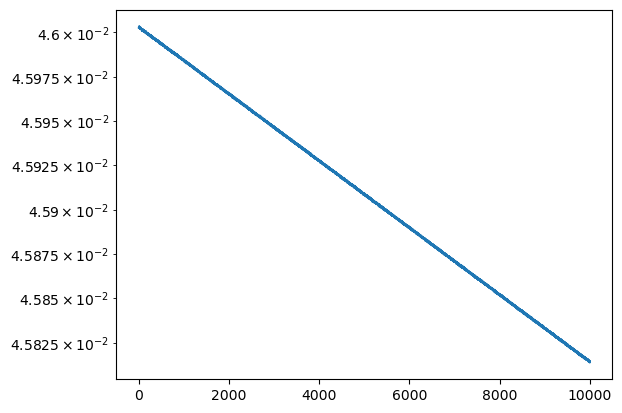

In [187]:
epochs = 10000
lr = 1e-8
losses = np.zeros(epochs)
optimizer = torch.optim.Adam(pde_img_model.parameters(), lr=lr, weight_decay=1e-6)
nl = 0.0001 * torch.std(u_data)

for epoch in range(epochs):
    optimizer.zero_grad()
    u_pred_img = pde_img_model()
    loss = torch.mean((u_pred_img - (u_data + nl*torch.randn_like(u_data)))**2)
    loss.backward()
    optimizer.step()
    losses[epoch] = loss.item()
    # check if nan, if so, exit
    if torch.isnan(loss):
        print(f'Epoch {epoch}: Loss is nan, exiting')
        break
    if epochs < 20 or epoch % (epochs//20) == 0 or epoch == epochs-1:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
        for i, p in enumerate(pde_img_model.parameters()):
            print(f'Parameter {i} gradient norm: {p.grad.norm():.2e}')

plt.figure()
plt.semilogy(losses)

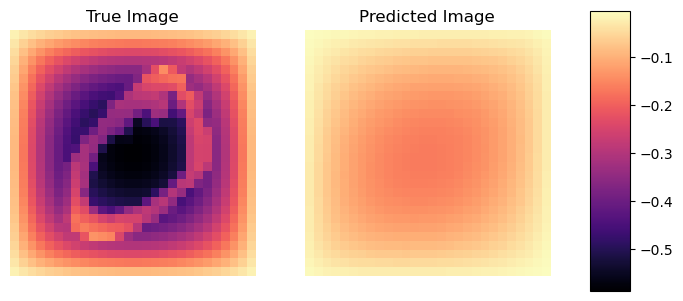

In [190]:
# compare final image to true
vs = {'vmin': min(u_data.min(), u_pred_img.min()),\
      'vmax': max(u_data.max(), u_pred_img.max())}
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(u_data, cmap='magma', **vs)
axs[0].axis('off')
axs[0].set_title('True Image')
axs[1].imshow(u_pred_img.detach(), cmap='magma', **vs)
axs[1].axis('off')
axs[1].set_title('Predicted Image')
# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[1].imshow(u_pred_img.detach(), cmap='magma', **vs), cax=cbar_ax)